### 
- **Author:** Soodeh
- **Last Updated:** Oct2025
- **Description:** Validation of latent feature–trait/Exposure associations

### This script validates the relationships between Cardio4D-VAE latent features and conventional cardiac imaging traits.


- **Perform multivariable regression** to quantify the variance explained by latent components across imaging traits.

- **Validate associations** between Cardio4D-VAE latent features and conventional cardiac imaging parameters.

- **Compute trait-wise explainability and statistical significance** of individual latent components.

- **Assess structure–function relationships** by evaluating the explanatory power of latent features.

- **Environmental exposure–motion latent component associations**


In [ ]:
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pyvista as pv


import matplotlib as mpl

mpl.rcParams.update({
    "pdf.fonttype": 42,   # use TrueType (Type 42) 
    "ps.fonttype": 42,
    "svg.fonttype": "none",  # keep text as text in SVG, not paths
    "text.usetex": False,    # LaTeX forces outlines
    "font.family": "sans-serif",
    "font.sans-serif": ["Arial", "Helvetica", "DejaVu Sans"]  # use a common font
})



##### Outliers

In [2]:
outlier_file_path = 'X:/UKBB_40616_deepmesh/outliers_80k_total.csv'


outlier_df = pd.read_csv(outlier_file_path)
len(outlier_df)

326

In [ ]:


emb = 32
num_subjects = 78113

INP_DIR = r'S:/sk/'
RESULTS_DIR_bvae=f'P:/motion_code/DR_motion/SPTVAE/results_VAE_optuna_10k/VAE_32'
# imaging_traits_path = f'{INP_DIR}/img_features_all_rf_imputed_81k_with_biochemistry_18545.csv'
imaging_traits_path = f'{INP_DIR}/img_features_all_rf_imputed_81k_with_biochemistry_18545_ethnicity.csv' ## ethnicity is numeric


## 80 k
num_subjects = 78113
motion_comps_path = f'{RESULTS_DIR_bvae}/LVmyo_motion_embeddings_{emb}_VAE_NS_{num_subjects}.csv'


motion_comp = pd.read_csv(motion_comps_path)
motion_comp
y = motion_comp[[col for col in motion_comp.columns if col != 'eid_18545']]
print(y)



### Finding distribution of IDPs

In [ ]:
import pandas as pd
import numpy as np
## 80 k
num_subjects = 78113
motion_comps_path = f'{RESULTS_DIR_bvae}/LVmyo_motion_embeddings_{emb}_VAE_NS_{num_subjects}.csv'

# --- Load data (keep a full copy of imaging traits for ethnicity/sex baselines) ---
motion_comp = pd.read_csv(motion_comps_path)

imaging_traits_full = pd.read_csv(imaging_traits_path)  # full, untouched copy


imaging_traits_lr = pd.read_csv(imaging_traits_path)
imaging_traits_lr = imaging_traits_lr.drop(columns=[
    'Ethnicity','BMI_img',
    # 'DBP_avg','SBP_avg',
    'MAP_avg','height','weight',
    'Ell_1','Ell_2','Ell_3','Ell_4','Ell_5','Ell_6',
    'Ecc_AHA_1','Ecc_AHA_2','Ecc_AHA_3','Ecc_AHA_4','Ecc_AHA_5','Ecc_AHA_6',
    'Ecc_AHA_7','Ecc_AHA_8','Ecc_AHA_9','Ecc_AHA_10','Ecc_AHA_11','Ecc_AHA_12',
    'Ecc_AHA_13','Ecc_AHA_14','Ecc_AHA_15','Ecc_AHA_16',
    'Err_AHA_1','Err_AHA_2','Err_AHA_3','Err_AHA_4','Err_AHA_5','Err_AHA_6',
    'Err_AHA_7','Err_AHA_8','Err_AHA_9','Err_AHA_10','Err_AHA_11','Err_AHA_12',
    'Err_AHA_13','Err_AHA_14','Err_AHA_15','Err_AHA_16',
    'WT_AHA_1','WT_AHA_2','WT_AHA_3','WT_AHA_4','WT_AHA_5','WT_AHA_6',
    'WT_AHA_7','WT_AHA_8','WT_AHA_9','WT_AHA_10','WT_AHA_11','WT_AHA_12',
    'WT_AHA_13','WT_AHA_14','WT_AHA_15','WT_AHA_16',
    'WT_Max_AHA_1','WT_Max_AHA_2','WT_Max_AHA_3','WT_Max_AHA_4','WT_Max_AHA_5',
    'WT_Max_AHA_6','WT_Max_AHA_7','WT_Max_AHA_8','WT_Max_AHA_9','WT_Max_AHA_10',
    'WT_Max_AHA_11','WT_Max_AHA_12','WT_Max_AHA_13','WT_Max_AHA_14','WT_Max_AHA_15','WT_Max_AHA_16',
    'Cholesterol','Creatinine','HbA1c','HDL_cholesterol','LDL_direct'
], errors='ignore')

# --- Merge with motion components on eid_18545 ---
merged_df1 = pd.merge(motion_comp, imaging_traits_lr, on='eid_18545', how='inner')

# ===== 1) Mean & SD for all imaging_traits_lr columns (excluding identifiers/sex) =====
# Identify which columns came from imaging_traits_lr
imaging_lr_cols = [c for c in imaging_traits_lr.columns if c not in ['eid_18545', 'Sex']]

# Keep only numeric columns among those
numeric_imaging_cols = [c for c in imaging_lr_cols if pd.api.types.is_numeric_dtype(merged_df1[c])]

imaging_summary = merged_df1[numeric_imaging_cols].agg(['mean', 'std']).T
imaging_summary = imaging_summary.rename(columns={'mean':'Mean', 'std':'SD'})
# Optional: save
# imaging_summary.to_csv(f"{RESULTS_DIR_bvae}/imaging_traits_lr_mean_sd.csv", index=True)


eth = imaging_traits_full[['eid_18545', 'Ethnic_background']].drop_duplicates('eid_18545')
merged_with_eth = merged_df1[['eid_18545']].merge(eth, on='eid_18545', how='left')

den_m = merged_with_eth['Ethnic_background'].notna()
pct_white_merged = (
    merged_with_eth.loc[den_m, 'Ethnic_background']
    .astype(str).str.strip().str.lower().eq('white')
    .mean() * 100
)




# ===== 2) % Sex == 0 (female) =====
def percent_true(series_bool):
    # denominator excludes missing values
    return (series_bool.mean() * 100.0) if series_bool.notna().any() else np.nan

# In merged cohort
pct_female_merged = percent_true(merged_df1['Sex'].eq(0))

# In full imaging set (if Sex exists there)
pct_female_full = np.nan
if 'Sex' in imaging_traits_full.columns:
    pct_female_full = percent_true(imaging_traits_full['Sex'].eq(0))

### Femal=0   Male=1
# Robust male %: among non-missing Sex, it's 100 - female%
sex_nonmissing = merged_df1['Sex'].dropna()
pct_male_merged = (1.0 - sex_nonmissing.eq(0).mean()) * 100.0

# Add % rows to the summary (values in the 'Mean' column; SD is NA)
extras = pd.DataFrame(
    {
        'Mean': [pct_white_merged, pct_female_merged, pct_male_merged],
        'SD':   [np.nan,           np.nan,            np.nan]
    },
    index=['Pct_White', 'Pct_Female', 'Pct_Male']
)

# Combine and save
imaging_summary_with_pct = pd.concat([imaging_summary, extras], axis=0)
imaging_summary_with_pct.to_csv(f"{RESULTS_DIR_bvae}/imaging_traits_lr_mean_sd.csv", index=True)

print("\n=== Saved with % rows appended ===")
print(imaging_summary_with_pct.tail(5))


# ===== 3) % White ethnicity (coding per your guide) =====
print("\n===Percentage White (merged cohort) === ")
print(f"{pct_white_merged:.2f}%")
# --- Pretty print ---
print("\n=== Imaging Traits (LR) — Mean & SD (merged cohort) ===")
print(imaging_summary)

print("\n=== Sex (0 = female) ===")
print(f"Percentage female (merged cohort): {pct_female_merged:.2f}%")
if not np.isnan(pct_female_full):
    print(f"Percentage female (full imaging set): {pct_female_full:.2f}%")


# pct_cols = pd.DataFrame(
#     {'Pct_White': [pct_white_merged],
#      'Pct_Female': [pct_female_merged],
#      'Pct_Male': [pct_male_merged]},
#     index=['Overall_%']
# )
# out_wide = pd.concat([imaging_summary, pct_cols], axis=1)
# out_wide.to_csv(f"{RESULTS_DIR_bvae}/imaging_traits_lr_mean_sd.csv")

# --- Count number of subjects ---
n_subjects = merged_df1.shape[0]

# --- Add percentage rows ---
sex_nonmissing = merged_df1['Sex'].dropna()
pct_male_merged = (1.0 - sex_nonmissing.eq(0).mean()) * 100.0

extras = pd.DataFrame(
    {
        'Mean': [pct_white_merged, pct_female_merged, pct_male_merged, n_subjects],
        'SD':   [np.nan,           np.nan,            np.nan,          np.nan]
    },
    index=['Pct_White (%)', 'Pct_Female (%)', 'Pct_Male (%)', 'N_Subjects']
)

# --- Combine and save ---
imaging_summary_with_info = pd.concat([imaging_summary, extras], axis=0)
imaging_summary_with_info.to_csv(f"{RESULTS_DIR_bvae}/imaging_traits_lr_mean_sd.csv", index=True)

print("\n=== Saved with % rows and subject count appended ===")
print(imaging_summary_with_info.tail(6))


=== Saved with % rows appended ===
                 Mean         SD
LAV_maxi    39.236957  12.004664
RASVi       21.463272   6.919184
Pct_White   96.410539        NaN
Pct_Female  52.929492        NaN
Pct_Male    47.070508        NaN

===Percentage White (merged cohort) === 
96.41%

=== Imaging Traits (LR) — Mean & SD (merged cohort) ===
                          Mean          SD
LVEF                 59.650150    6.440000
LVCO                  5.365379    1.241520
RVEF                 57.247866    6.497332
LAEF                 59.990152    9.756428
RAEF                 46.779215    9.111898
AAo_max_area        865.164586  192.682302
AAo_min_area        790.681332  187.119228
AAo_distensibility    1.648357    2.743310
DAo_max_area        480.375656   99.505466
DAo_min_area        426.455356   94.190607
DAo_distensibility    2.163123    1.526815
WT_Global             5.692368    0.766711
WT_Max_Global         9.504321    1.746309
Ecc_Global          -22.345037    3.590768
Err_Global     

### Component correlation

(32, 32)


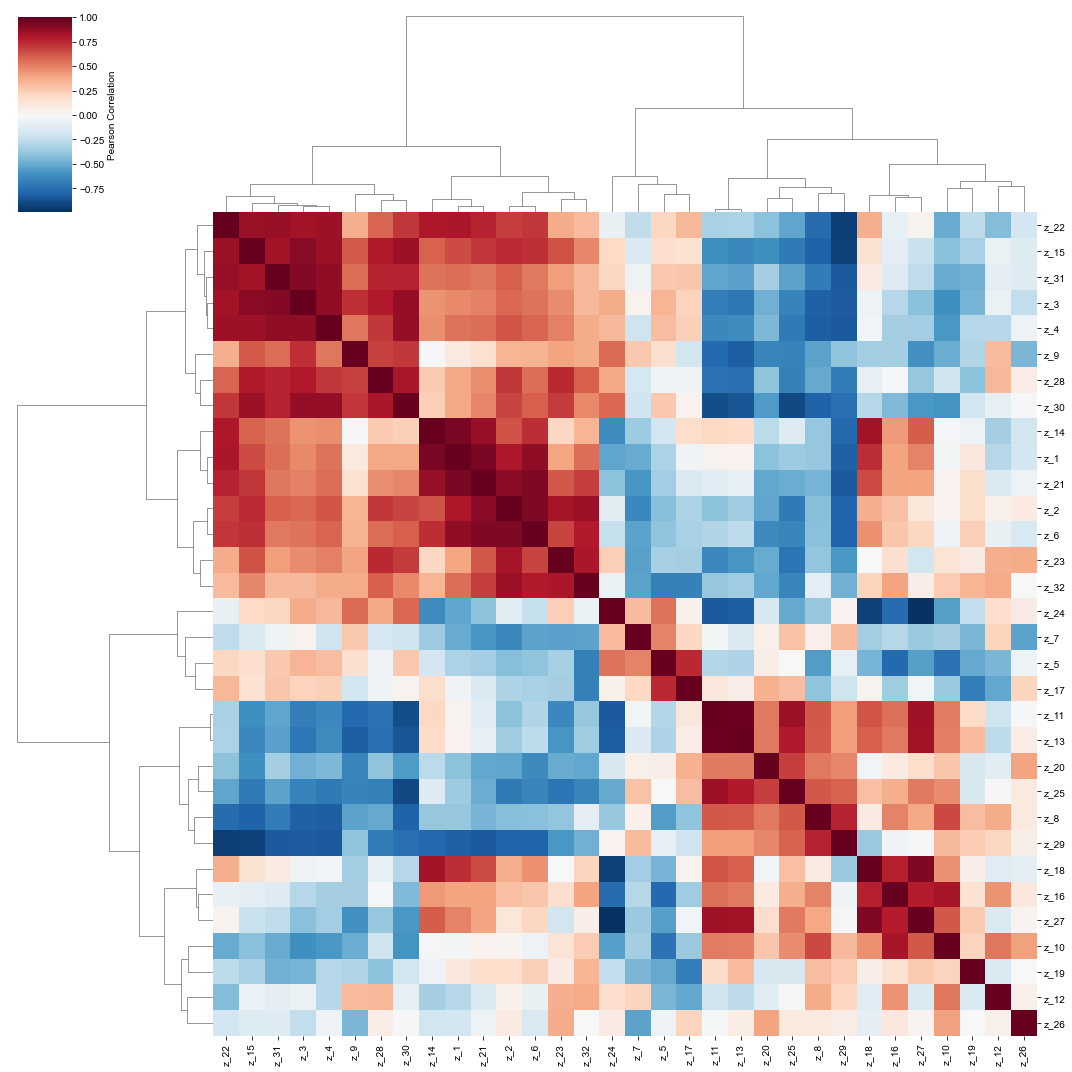

In [4]:
# Pearson correlation matrix between components
corr_matrix_comp = y.corr(method='pearson')
print(corr_matrix_comp.shape)   # should be (n_components, n_components)

import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(
    corr_matrix_comp,
    cmap='RdBu_r',
    center=0,
    figsize=(15, 15),
    metric='euclidean',    # clustering metric
    method='ward',          # linkage method
    cbar_kws={'label': 'Pearson Correlation'}  #  add label here
)

# save_path = f"{RESULTS_DIR_bvae}/corr_latenet_80k.pdf"
# plt.savefig(save_path, dpi=300)
plt.show()

###  Multivariable linear regression model


##### Global association between all latent components and each imaging-derived trait and effect of individual motion-derived components

In [ ]:
import statsmodels.api as sm
# covariates = ['age', 'sex', 'BMI']  # Add your covariates here
# covariates = ["age_at_MRI", "Sex", "Ethnic_background",  "BMI"]
# covariates = ["age_at_MRI", "Sex", "BMI"]
# covariates = ["age_at_MRI", "Sex", "Ethnicity", "BSA"]


motion_comp = pd.read_csv(motion_comps_path)
print(motion_comp)

imaging_traits_lr= pd.read_csv(imaging_traits_path)
print(imaging_traits_lr)
# imaging_traits_lr = imaging_traits_lr.drop(columns=['weight', 'age_at_MRI', 'Sex',  'height',
#                                               'Ethnic_background', 'Cholesterol', 'Creatinine', 'HbA1c', 'HDL_cholesterol', 'LDL_direct'])

imaging_traits_lr = imaging_traits_lr.drop(columns=[
       'Ethnic_background',
       'BMI_img',
       'DBP_avg',
       'SBP_avg',
       'MAP_avg',
       'height',
       'weight' , 
       'Ell_1', 'Ell_2', 'Ell_3', 'Ell_4','Ell_5', 'Ell_6',
       'Ecc_AHA_1', 'Ecc_AHA_2', 'Ecc_AHA_3',
       'Ecc_AHA_4', 'Ecc_AHA_5', 'Ecc_AHA_6', 'Ecc_AHA_7', 'Ecc_AHA_8',
       'Ecc_AHA_9', 'Ecc_AHA_10', 'Ecc_AHA_11', 'Ecc_AHA_12', 'Ecc_AHA_13',
       'Ecc_AHA_14', 'Ecc_AHA_15', 'Ecc_AHA_16',
       'Err_AHA_1',
       'Err_AHA_2', 'Err_AHA_3', 'Err_AHA_4', 'Err_AHA_5', 'Err_AHA_6',
       'Err_AHA_7', 'Err_AHA_8', 'Err_AHA_9', 'Err_AHA_10', 'Err_AHA_11',
       'Err_AHA_12', 'Err_AHA_13', 'Err_AHA_14', 'Err_AHA_15', 'Err_AHA_16',
       'WT_AHA_1', 'WT_AHA_2',
       'WT_AHA_3', 'WT_AHA_4', 'WT_AHA_5', 'WT_AHA_6', 'WT_AHA_7', 'WT_AHA_8',
       'WT_AHA_9', 'WT_AHA_10', 'WT_AHA_11', 'WT_AHA_12', 'WT_AHA_13',
       'WT_AHA_14', 'WT_AHA_15', 'WT_AHA_16',
       'WT_Max_AHA_1',
       'WT_Max_AHA_2', 'WT_Max_AHA_3', 'WT_Max_AHA_4', 'WT_Max_AHA_5',
       'WT_Max_AHA_6', 'WT_Max_AHA_7', 'WT_Max_AHA_8', 'WT_Max_AHA_9',
       'WT_Max_AHA_10', 'WT_Max_AHA_11', 'WT_Max_AHA_12', 'WT_Max_AHA_13',
       'WT_Max_AHA_14', 'WT_Max_AHA_15', 'WT_Max_AHA_16',
       'Cholesterol', 'Creatinine', 'HbA1c', 'HDL_cholesterol', 'LDL_direct'
       ])
print(imaging_traits_lr.columns)
# Ensure imaging traits have a matching 'eid_18545' column
# Merge the SpaceMAP components with imaging traits on 'eid_18545'
merged_df = pd.merge(motion_comp, imaging_traits_lr, on='eid_18545')
# merged_df = pd.merge(motion_comp, imaging_traits, on='eid_18545')



print(merged_df.head(5))
############## Adjust to the covariance: ########################################

# ===================== Adjust for Covariates =========================

covariates = ["age_at_MRI", "Sex", "Ethnicity", "BSA"]



print(f"Using covariates: {covariates}")
# ======================================================================
# Update traits list NOW after merge
components = [col for col in motion_comp.columns if col.startswith('z_')]
traits = [col for col in merged_df.columns if col not in ['eid_18545'] + components + ["age_at_MRI", "Sex", "Ethnicity", "BSA"]]


print(components)
print(traits)
# traits = [col for col in merged_df.columns if col not in ['eid_18545'] + components + ["age_at_MRI", "Sex", "BMI"] + [col for col in merged_df.columns if col.startswith("Ethnic_background_")]]
# ======================================================================
# standarizing
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
merged_df[components] = scaler.fit_transform(merged_df[components])
merged_df[traits] = scaler.fit_transform(merged_df[traits])

print(merged_df.head())
##################################################################################
### Total R² per Trait (Aggregated)
##################################################################################
## Global
## Per-trait multivariable model (for  R2): 
## For each imaging trait, we regress the (standardized) trait on all motion latent components plus covariates (age at MRI, sex, ethnicity, BSA).

## Yi​(cardiac trait)=β0​+β1​⋅LatentPhenotypei​+k∑​γk​⋅Covariateik​+ϵi​
##################################################################################

trait_r2_list = []

for trait in traits:
    X = merged_df[components + covariates]
    X = sm.add_constant(X)
    y = merged_df[trait]
    model = sm.OLS(y, X).fit()
    
    # Store trait name and R²
    trait_r2_list.append({
        'Trait': trait,
        'R_squared_total': model.rsquared,
        'R_squared_adj': model.rsquared_adj  # optional
    })

# Convert to DataFrame
r2_df = pd.DataFrame(trait_r2_list)

# Sort by most explained variance
r2_df = r2_df.sort_values(by='R_squared_total', ascending=False)
print(r2_df.head(10))
# r2_df.to_csv(f"{RESULTS_DIR_bvae}/r2_df_80k_traits.csv", index=False)


##################################################################################
#### Component–Trait Pair
##################################################################################
## Individual

## Component–trait regression for effects & p-values):

## Trait_i ~ Component_i + age_at_MRI + Sex + Ethnicity + BSA

## For every pair of latent component and trait, you regress the (standardized) trait on that single component, 
## adjusting for the same covariates, and extract the component’s coefficient, p-value, and model R2
##################################################################################

# effect_sizes = []
# p_values = []
# component_list = []
# trait_list = []
# r_squared_list = []

# for comp in components:
#     for trait in traits:
#         X = merged_df[[comp] + covariates]
#         X = sm.add_constant(X)
#         y = merged_df[trait]
#         model = sm.OLS(y, X).fit() ## linear regression Ordinary Least Squares

#         beta = model.params[comp]
#         p_val = model.pvalues[comp]
#         r2 = model.rsquared


#         effect_sizes.append(beta)
#         p_values.append(p_val)
#         component_list.append(comp)
#         trait_list.append(trait)
#         r_squared_list.append(r2)


# # Create DataFrame for plotting
# volcano_df = pd.DataFrame({
#     'Component': component_list,
#     'Trait': trait_list,
#     'Effect_Size': effect_sizes,
#     'P_Value': p_values,
#     'R_squared': r_squared_list

# })
# # Avoid log10(0) by replacing zeros with a very small number
# # epsilon = 1e-300
# # volcano_df['P_Value'] = volcano_df['P_Value'].clip(lower=epsilon)
# # volcano_df['-log10(P_Value)'] = -np.log10(volcano_df['P_Value'])


# # Replace 0 with the smallest positive float (to avoid -log10(0) = inf)
# # volcano_df['P_Value'] = volcano_df['P_Value'].replace(0, np.nextafter(0, 1))

# # Compute -log10(p-value)
# volcano_df['-log10(P_Value)'] = -np.log10(volcano_df['P_Value'])
# volcano_df


from scipy import stats  # only needed if you want to build CIs manually

effect_sizes = []
p_values = []
se_list = []
ci_low_list = []
ci_high_list = []
component_list = []
trait_list = []
r_squared_list = []

for comp in components:
    for trait in traits:
        X = merged_df[[comp] + covariates]
        X = sm.add_constant(X)
        y = merged_df[trait]

        # Default OLS
        model = sm.OLS(y, X).fit()
        # If you want heteroskedasticity-robust CIs instead, use:
        # model = sm.OLS(y, X).fit(cov_type="HC3")

        beta = model.params[comp]
        p_val = model.pvalues[comp]
        r2 = model.rsquared

        # --- CI & SE from statsmodels ---
        se = model.bse[comp]
        ci_l, ci_u = model.conf_int(alpha=0.05).loc[comp]  # 95% CI

        effect_sizes.append(beta)
        p_values.append(p_val)
        se_list.append(se)
        ci_low_list.append(ci_l)
        ci_high_list.append(ci_u)
        component_list.append(comp)
        trait_list.append(trait)
        r_squared_list.append(r2)

volcano_df = pd.DataFrame({
    'Component': component_list,
    'Trait': trait_list,
    'Effect_Size': effect_sizes,
    'SE': se_list,
    'CI_L': ci_low_list,
    'CI_U': ci_high_list,
    'P_Value': p_values,
    'R_squared': r_squared_list
})

# Add -log10(P) if you like
volcano_df['-log10(P_Value)'] = -np.log10(volcano_df['P_Value'])


In [12]:
volcano_df

,Component,Trait,Effect_Size,SE,CI_L,CI_U,P_Value,R_squared,-log10(P_Value)
0,z_1,LVEF,-0.008405,0.003481,-0.015229,-0.001581,1.577069e-02,0.080463,1.802149
1,z_1,LVCO,0.032955,0.003140,0.026801,0.039110,9.466907e-26,0.251950,25.023792
2,z_1,RVEF,-0.113002,0.003410,-0.119685,-0.106320,3.351868e-239,0.118042,238.474713
3,z_1,LAEF,0.001283,0.003530,-0.005635,0.008201,7.162089e-01,0.054800,0.144960
4,z_1,RAEF,0.024259,0.003490,0.017419,0.031100,3.647613e-12,0.075998,11.437991
...,...,...,...,...,...,...,...,...,...
1019,z_32,RAV_maxi,0.218871,0.003705,0.211610,0.226132,0.000000e+00,0.114920,inf
1020,z_32,LASVi,0.194783,0.003817,0.187302,0.202265,0.000000e+00,0.060398,inf
1021,z_32,LAV_mini,0.139439,0.003852,0.131890,0.146988,1.344707e-284,0.043191,283.871372
1022,z_32,LAV_maxi,0.194401,0.003871,0.186815,0.201987,0.000000e+00,0.033835,inf


In [12]:
# Mean R² per latent component
## Component–trait partial (univariate)
representative_latents = volcano_df.groupby('Component')['R_squared'].mean().reset_index()
representative_latents = representative_latents.sort_values(by='R_squared', ascending=False)

print(representative_latents.head(10))

   Component  R_squared
8       z_17   0.226630
27       z_5   0.214629
7       z_16   0.200647
3       z_12   0.190126
18      z_26   0.189869
25      z_32   0.189845
28       z_6   0.178078
12      z_20   0.175848
10      z_19   0.175451
9       z_18   0.174192


##### Visualization : Effect of individual motion-derived components

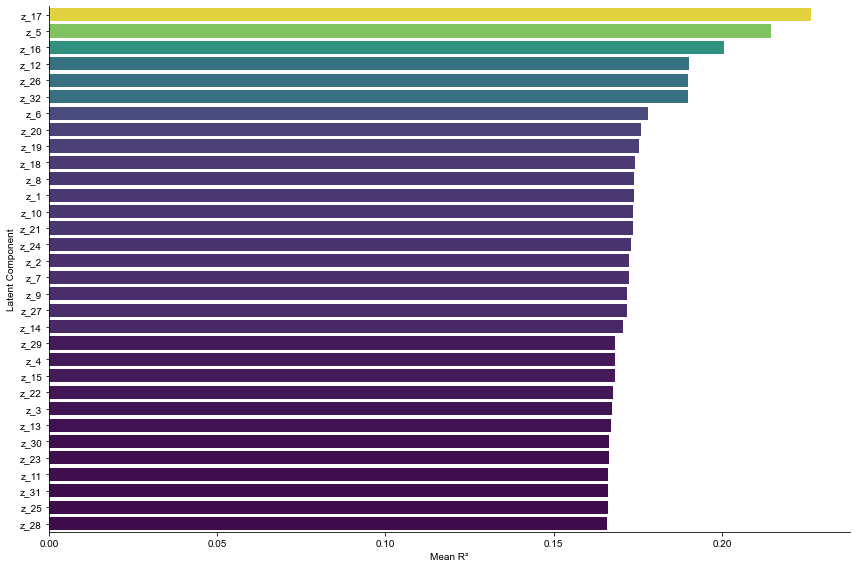

In [211]:
import matplotlib.pyplot as plt
import seaborn as sns

# # Mean R² per latent component
# representative_latents = volcano_df.groupby('Component')['R_squared'].mean().reset_index()
# representative_latents = representative_latents.sort_values(by='R_squared', ascending=False)

# print(representative_latents.head(10))

# # Sort by mean R² (already done, but just in case)
# representative_latents = representative_latents.sort_values(by='R_squared', ascending=False)
# representative_latents.to_csv(f"{RESULTS_DIR_bvae}/representative_latents_32_80k.csv", index=False)
representative_latents = pd.read_csv(f"{RESULTS_DIR_bvae}/representative_latents_32_80k.csv")
# Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    data=representative_latents,
    x='R_squared',
    y='Component',
    palette='viridis', #yellow = high
    hue='R_squared',        # color mapped to value
    dodge=False,
    legend=False
)
plt.xlabel('Mean R²') ##Across Imaging Traits
plt.ylabel('Latent Component')
# plt.title('Average Variance Explained by Each Latent Component')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

# save_path = f"{RESULTS_DIR_bvae}/R2_representative_latents_80k_1.png"
# plt.savefig(save_path, dpi=300)

# save_path = f"{RESULTS_DIR_bvae}/R2_representative_latents_80k_1.svg"
# plt.savefig(save_path, dpi=300)

save_path = f"{RESULTS_DIR_bvae}/R2_representative_latents_80k_1.pdf"
plt.savefig(save_path, dpi=300)
plt.show()


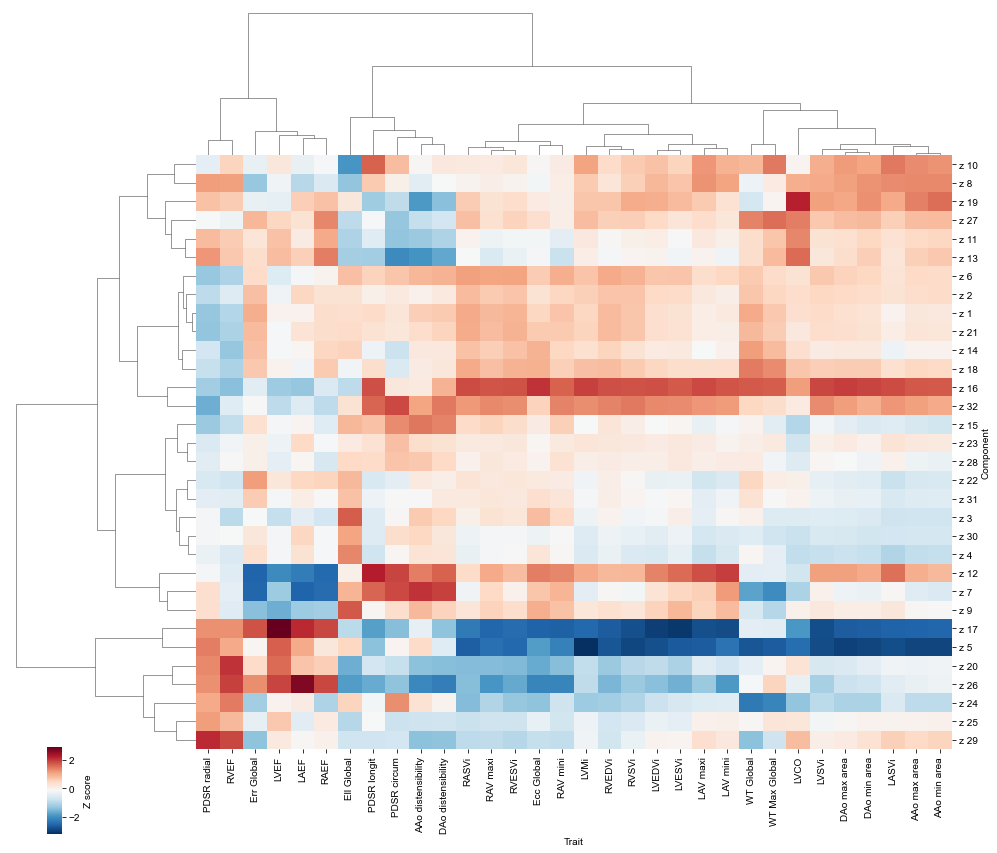

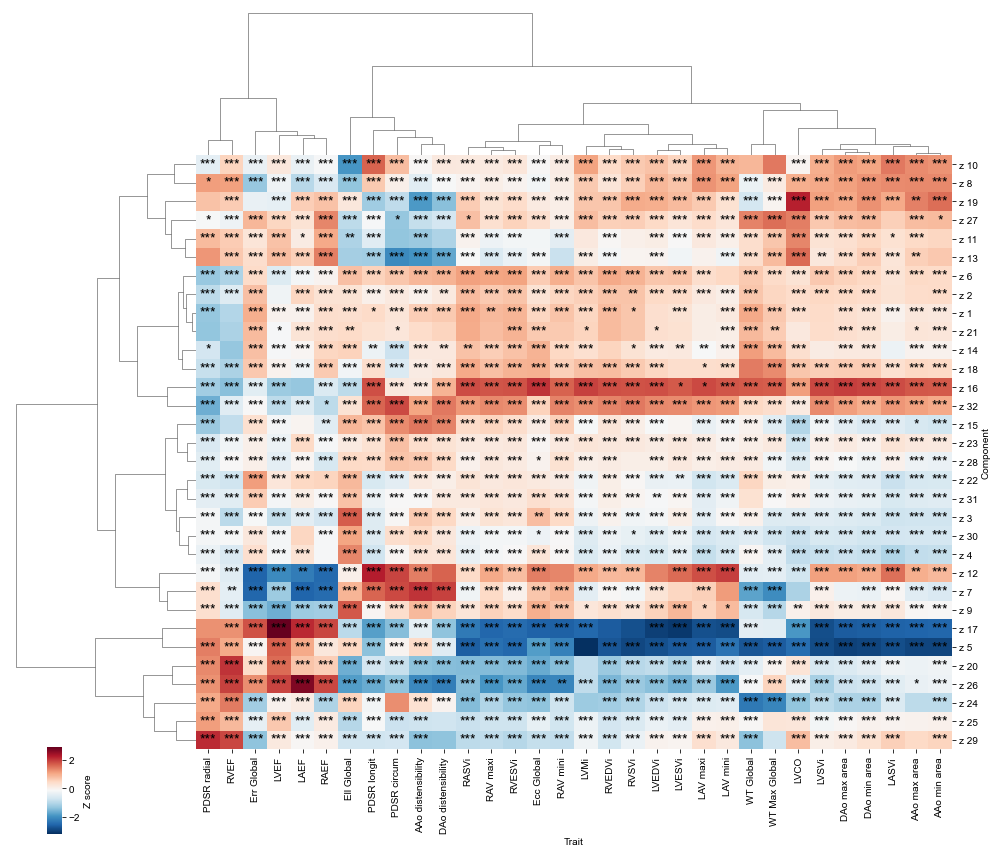

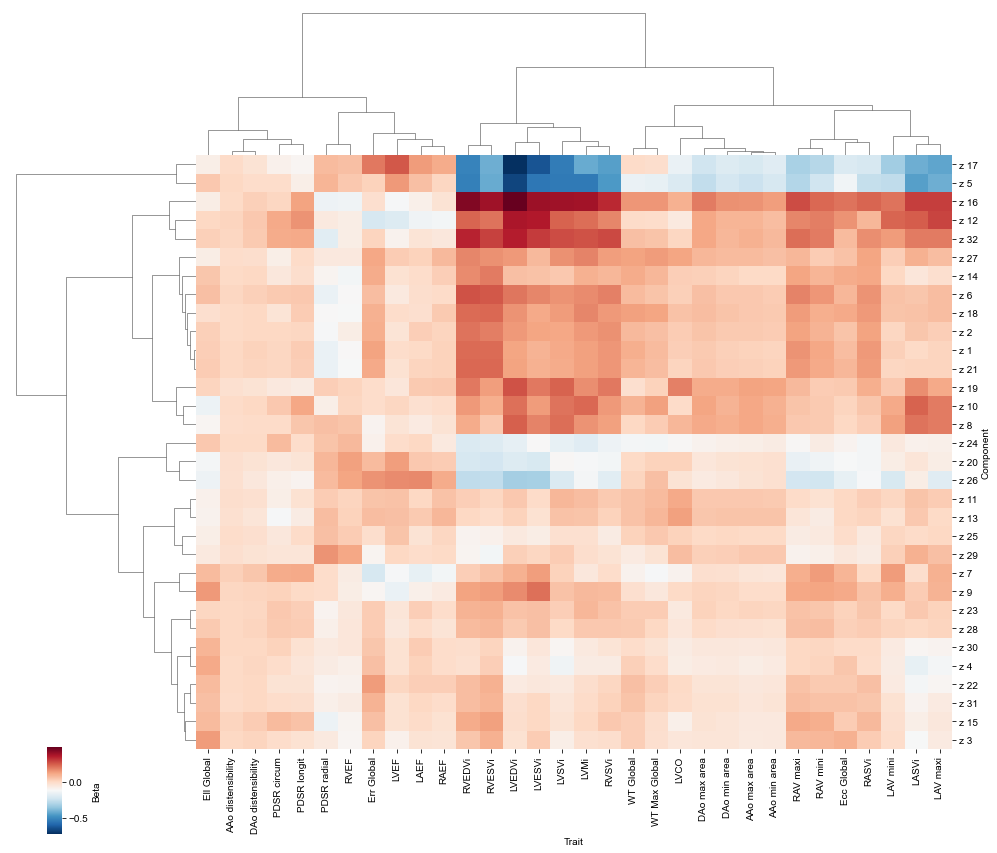

In [ ]:
effect_matrix = volcano_df.pivot(index='Component', columns='Trait', values='Effect_Size')
from sklearn.preprocessing import StandardScaler

'''
Default behavior: it standardizes each column of effect matrix independently.
Rows = latent components (from VAE)
Columns = IDP
The result is:
For each IDP, all betas (across components) are converted to z-scores.
That means:
Mean of each IDP’s betas = 0
Standard deviation = 1

'''


effect_matrix_scaled = pd.DataFrame(
    StandardScaler().fit_transform(effect_matrix),
    index=effect_matrix.index,
    columns=effect_matrix.columns
)


effect_matrix = pd.DataFrame(
    effect_matrix,
    index=effect_matrix.index,
    columns=effect_matrix.columns
)


import seaborn as sns
import matplotlib.pyplot as plt



# Clustered heatmap
# sns.clustermap(effect_matrix_scaled, cmap='RdBu_r', figsize=(14, 12), metric='euclidean', method='ward', cbar_kws={'shrink': 0.3, 'label': 'Effect Size'},cbar_pos=(0.05, 0.03, 0.015, 0.1)),  # (x, y, width, height))

g = sns.clustermap(effect_matrix_scaled, cmap='RdBu_r', figsize=(14, 12), metric='euclidean', method='ward', cbar_kws={'shrink': 0.3, 'label': 'Z score'},cbar_pos=(0.05, 0.03, 0.015, 0.1))  # (x, y, width, height))

x_labels = g.data2d.columns
y_labels = g.data2d.index

# Replace underscores with spaces in labels
x_labels = [label.replace("_", " ") for label in x_labels]
y_labels = [label.replace("_", " ") for label in y_labels]
# Apply updated labels
g.ax_heatmap.set_xticklabels(x_labels, rotation=90)
g.ax_heatmap.set_yticklabels(y_labels)

save_path = f"{RESULTS_DIR_bvae}/Effectsize_triats_latents_80k_zscore.pdf"
# plt.savefig(save_path, dpi=300)
plt.show()



## =========== FDR significant =====================================================

# Function to convert p-values to stars
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# Pivot p-values and map to stars
sig_markers = volcano_df.pivot(
    index="Component", columns="Trait",   values="P_Value_FDR_corrected" ###values="P_Value"
).applymap(p_to_stars)

g = sns.clustermap(
    effect_matrix_scaled,
    cmap='RdBu_r',
    figsize=(14, 12),
    metric='euclidean',
    method='ward',
    cbar_kws={'shrink': 0.3, 'label': 'Z score'},
    cbar_pos=(0.05, 0.03, 0.015, 0.1)

)
# Get reordered labels
x_labels = g.data2d.columns
y_labels = g.data2d.index

# Replace underscores with spaces in labels
x_labels = [label.replace("_", " ") for label in x_labels]
y_labels = [label.replace("_", " ") for label in y_labels]

# Update the tick labels on the heatmap
g.ax_heatmap.set_xticklabels(x_labels, rotation=90)
g.ax_heatmap.set_yticklabels(y_labels)

# Loop over each cell and add text
for y, trait in enumerate(g.data2d.columns):
    for x, component in enumerate(g.data2d.index):
        star = sig_markers.loc[component, trait]
        if star != "":
            g.ax_heatmap.text(
                x + 0.5, y + 0.5, star,
                ha='center', va='center', color='black', fontsize=14,
            )
            
           
save_path = f"{RESULTS_DIR_bvae}/Effectsize_triats_latents_80k_zscore_FDR_sig.pdf"
plt.savefig(save_path, dpi=300)
plt.show()
 ## ========================================================================================
g = sns.clustermap(effect_matrix, cmap='RdBu_r', figsize=(14, 12), metric='euclidean', method='ward', cbar_kws={'shrink': 0.3, 'label': 'Beta'},cbar_pos=(0.05, 0.03, 0.015, 0.1))  # (x, y, width, height))
x_labels = g.data2d.columns
y_labels = g.data2d.index

# Replace underscores with spaces in labels
x_labels = [label.replace("_", " ") for label in x_labels]
y_labels = [label.replace("_", " ") for label in y_labels]
# Apply updated labels
g.ax_heatmap.set_xticklabels(x_labels, rotation=90)
g.ax_heatmap.set_yticklabels(y_labels)
save_path = f"{RESULTS_DIR_bvae}/Effectsize_triats_latents_80k_Beta.pdf"


# plt.savefig(save_path, dpi=300)
plt.show()

C:\Users\skalaie\AppData\Local\Temp\ipykernel_44844\2982235712.py:44: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


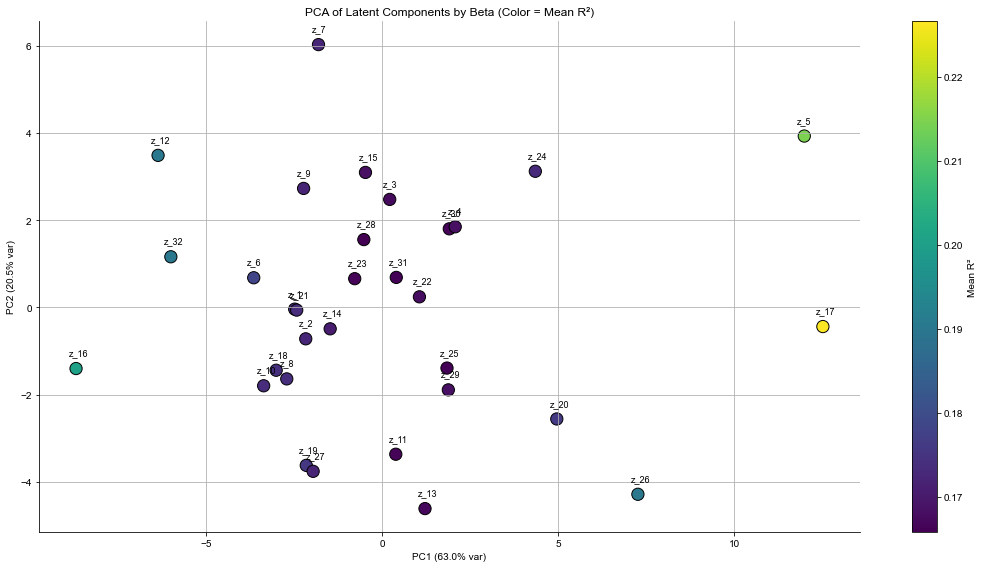

In [213]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(effect_matrix_scaled)


pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=effect_matrix_scaled.index)


r2_matrix = volcano_df.pivot(index='Component', columns='Trait', values='R_squared')
r2_matrix

mean_r2 = r2_matrix.mean(axis=1)

# Add Mean_R2 to pca_df
pca_df['Mean_R2'] = mean_r2


plt.figure(figsize=(15, 8))

# Capture the scatterplot in a variable
scatter = sns.scatterplot(
    x='PC1', y='PC2', data=pca_df,
    hue='Mean_R2', palette='viridis', s=150, edgecolor='black', legend=False
)
##edgecolor='none'


# Add labels
for i in pca_df.index:
    plt.text(pca_df.loc[i, 'PC1'] - 0.2, pca_df.loc[i, 'PC2']+ 0.3, i, fontsize=9)

# Add title and axis labels
# plt.title("PCA of Latent Components by Effect Size (Color = Mean R²)")
plt.title("PCA of Latent Components by Beta (Color = Mean R²)")

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")

# This will work now
norm = plt.Normalize(pca_df['Mean_R2'].min(), pca_df['Mean_R2'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
# sm.set_array([])  # required dummy array
cbar = plt.colorbar(sm)
cbar.set_label('Mean R²')

plt.grid(True)
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# save_path = f"{RESULTS_DIR_bvae}/pca_r2_latent_traits_80k.png"
# plt.savefig(save_path, dpi=300)

# save_path = f"{RESULTS_DIR_bvae}/pca_r2_latent_traits_80k.svg"
# plt.savefig(save_path, dpi=300)

save_path = f"{RESULTS_DIR_bvae}/pca_r2_latent_traits_80k_Beta.pdf"
plt.savefig(save_path, dpi=300)

plt.show()


##### Visualization : global association between all latent components and each imaging-derived trait

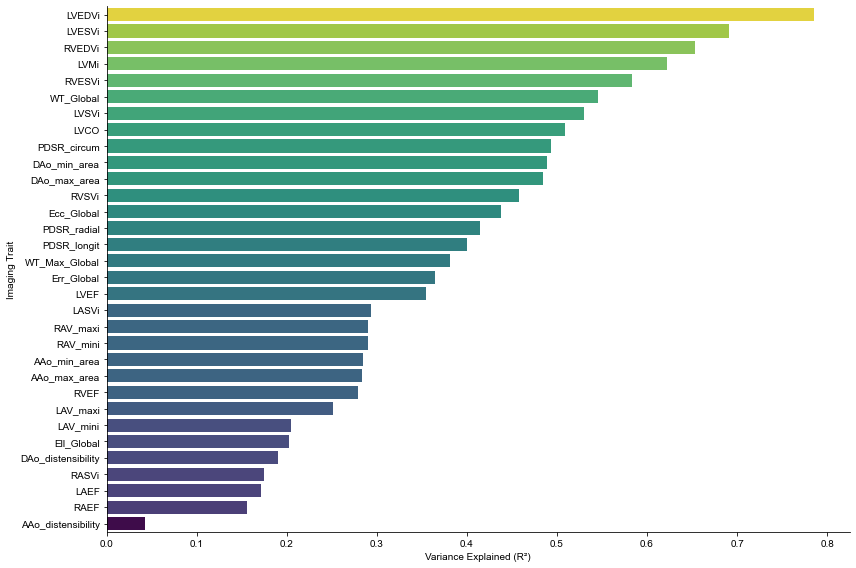

In [214]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sort for visual clarity
# r2_df_sorted = r2_df.sort_values(by='R_squared_total', ascending=False)
# r2_df_sorted .to_csv(f"{RESULTS_DIR_bvae}/r2_df_sorted_pertriats_80k.csv", index=False)
r2_df_sorted = pd.read_csv(f"{RESULTS_DIR_bvae}/r2_df_sorted_pertriats_80k.csv")

plt.figure(figsize=(12, 8))
sns.barplot(
    data=r2_df_sorted,
    y='Trait',  # horizontal bars
    x='R_squared_total',
    palette='viridis', # yellow to high
    hue='R_squared_total',        # color mapped to value
    dodge=False,
    legend=False
    
)
plt.xlabel('Variance Explained (R²)')
plt.ylabel('Imaging Trait')
# plt.title('Variance in Imaging Traits Explained by Latent Components + Covariates')
plt.tight_layout()
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# save_path = f"{RESULTS_DIR_bvae}/R2_80k_laten_covariate_1.png"
# plt.savefig(save_path, dpi=300)

# save_path = f"{RESULTS_DIR_bvae}/R2_80k_laten_covariate_1.svg"
# plt.savefig(save_path, dpi=300)

save_path = f"{RESULTS_DIR_bvae}/R2_80k_laten_covariate_1.pdf"
plt.savefig(save_path, dpi=300)

plt.show()

In [54]:
volcano_df

,Component,Trait,Effect_Size,P_Value,R_squared,-log10(P_Value),BF_Significant,FDR_Significant,P_Value_FDR_corrected,SE,CI_L,CI_U,OR,OR_SE
0,z_1,LVEF,-0.008405,1.577069e-02,0.080463,1.802149,False,True,1.742091e-02,0.003482,-0.015229,-0.001581,0.991630,0.003482
1,z_1,LVCO,0.032955,9.466907e-26,0.251950,25.023792,True,True,1.402911e-25,0.003141,0.026799,0.039112,1.033505,0.003141
2,z_1,RVEF,-0.113002,3.351868e-239,0.118042,238.474713,True,True,1.271227e-238,0.003422,-0.119709,-0.106296,0.893149,0.003422
3,z_1,LAEF,0.001283,7.162089e-01,0.054800,0.144960,False,False,7.247015e-01,0.003530,-0.005635,0.008201,1.001284,0.003530
4,z_1,RAEF,0.024259,3.647613e-12,0.075998,11.437991,True,True,4.752107e-12,0.003490,0.017418,0.031101,1.024556,0.003490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,z_32,RAV_maxi,0.218871,0.000000e+00,0.114920,inf,True,True,0.000000e+00,0.000000,0.218871,0.218871,1.244671,0.000000
1020,z_32,LASVi,0.194783,0.000000e+00,0.060398,inf,True,True,0.000000e+00,0.000000,0.194783,0.194783,1.215048,0.000000
1021,z_32,LAV_mini,0.139439,1.344707e-284,0.043191,283.871372,True,True,5.960950e-284,0.003868,0.131858,0.147020,1.149629,0.003868
1022,z_32,LAV_maxi,0.194401,0.000000e+00,0.033835,inf,True,True,0.000000e+00,0.000000,0.194401,0.194401,1.214583,0.000000


#### FDR correction (Benjamini-Hochberg)

In [ ]:

# BF correction
# Compute -log10(p-value)
volcano_df['-log10(P_Value)'] = -np.log10(volcano_df['P_Value'])
volcano_df 

# Threshold for traits (as in paper)
alpha = 0.05
num_tests = len(volcano_df)
print(num_tests)
bonf_threshold = alpha / num_tests  # Bonferroni correction
print("Bonferroni threshold =", bonf_threshold)

log_bonf_threshold = -np.log10(bonf_threshold)
print("Log Bonferroni threshold =",log_bonf_threshold)
volcano_df['BF_Significant'] = volcano_df['P_Value'] < bonf_threshold


# volcano_df.to_csv(f"{RESULTS_DIR_bvae}/volcano_results_80k_BF_{bonf_threshold}.csv", index=False)
volcano_df




from statsmodels.stats.multitest import multipletests

# FDR correction Benjamini-Hochberg
'''
rejected, pvals_corrected, alphacSidak, alphacBonf = multipletests(...)
'''
# Corrected FDR assignment
volcano_df['FDR_Significant'], volcano_df['P_Value_FDR_corrected'], _, _ = multipletests(
    volcano_df['P_Value'], alpha=0.05, method='fdr_bh'
)


volcano_df['-log10(P_Value_FDR_corrected)'] = -np.log10(volcano_df['P_Value_FDR_corrected'])


print(volcano_df.head())

fdr_threshold = volcano_df.loc[volcano_df['FDR_Significant'], 'P_Value'].max()
print("FDR raw p-value threshold:", fdr_threshold)
print("-log10(FDR threshold):", -np.log10(fdr_threshold))


# volcano_df.to_csv(f"{RESULTS_DIR_bvae}/volcano_results_80k_BF_{bonf_threshold}_FDR_{fdr_threshold}.csv", index=False)

volcano_df.to_csv(
    f"{RESULTS_DIR_bvae}/volcano_results_80k_BF_{bonf_threshold:.3f}_FDR_{fdr_threshold:.3f}.csv",
    index=False
)

volcano_df


1024
Bonferroni threshold = 4.8828125e-05
Log Bonferroni threshold = 4.311329952303793
  Component Trait  Effect_Size        SE      CI_L      CI_U        P_Value  \
0       z_1  LVEF    -0.008405  0.003481 -0.015229 -0.001581   1.577069e-02   
1       z_1  LVCO     0.032955  0.003140  0.026801  0.039110   9.466907e-26   
2       z_1  RVEF    -0.113002  0.003410 -0.119685 -0.106320  3.351868e-239   
3       z_1  LAEF     0.001283  0.003530 -0.005635  0.008201   7.162089e-01   
4       z_1  RAEF     0.024259  0.003490  0.017419  0.031100   3.647613e-12   

   R_squared  -log10(P_Value)  BF_Significant  FDR_Significant  \
0   0.080463         1.802149           False             True   
1   0.251950        25.023792            True             True   
2   0.118042       238.474713            True             True   
3   0.054800         0.144960           False            False   
4   0.075998        11.437991            True             True   

   P_Value_FDR_corrected  -log10(P_Value_

c:\Users\skalaie\.conda\envs\motion-env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Component,Trait,Effect_Size,SE,CI_L,CI_U,P_Value,R_squared,-log10(P_Value),BF_Significant,FDR_Significant,P_Value_FDR_corrected,-log10(P_Value_FDR_corrected)
0,z_1,LVEF,-0.008405,0.003481,-0.015229,-0.001581,1.577069e-02,0.080463,1.802149,False,True,1.742091e-02,1.758929
1,z_1,LVCO,0.032955,0.003140,0.026801,0.039110,9.466907e-26,0.251950,25.023792,True,True,1.402911e-25,24.852970
2,z_1,RVEF,-0.113002,0.003410,-0.119685,-0.106320,3.351868e-239,0.118042,238.474713,True,True,1.271227e-238,237.895777
3,z_1,LAEF,0.001283,0.003530,-0.005635,0.008201,7.162089e-01,0.054800,0.144960,False,False,7.247015e-01,0.139841
4,z_1,RAEF,0.024259,0.003490,0.017419,0.031100,3.647613e-12,0.075998,11.437991,True,True,4.752107e-12,11.323114
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,z_32,RAV_maxi,0.218871,0.003705,0.211610,0.226132,0.000000e+00,0.114920,inf,True,True,0.000000e+00,inf
1020,z_32,LASVi,0.194783,0.003817,0.187302,0.202265,0.000000e+00,0.060398,inf,True,True,0.000000e+00,inf
1021,z_32,LAV_mini,0.139439,0.003852,0.131890,0.146988,1.344707e-284,0.043191,283.871372,True,True,5.960950e-284,283.224684
1022,z_32,LAV_maxi,0.194401,0.003871,0.186815,0.201987,0.000000e+00,0.033835,inf,True,True,0.000000e+00,inf


C:\Users\skalaie\AppData\Local\Temp\ipykernel_47804\1557524123.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = plt.cm.get_cmap('tab20', len(sig_df['Trait'].unique()))


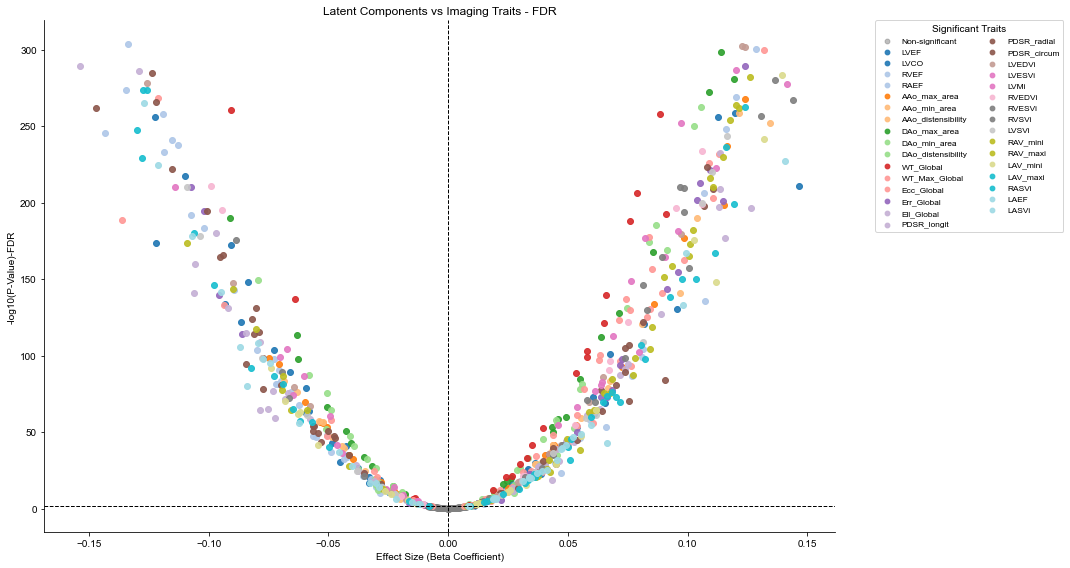

In [ ]:
from statsmodels.stats.multitest import multipletests

# FDR correction
# '''
# rejected, pvals_corrected, alphacSidak, alphacBonf = multipletests(...)
# '''
# # Corrected FDR assignment
# volcano_df['FDR_Significant'], volcano_df['P_Value_FDR_corrected'], _, _ = multipletests(
#     volcano_df['P_Value'], alpha=0.05, method='fdr_bh'
# )

# print(volcano_df.head())

# fdr_threshold = volcano_df.loc[volcano_df['FDR_Significant'], 'P_Value'].max()
# print("FDR raw p-value threshold:", fdr_threshold)
# print("-log10(FDR threshold):", -np.log10(fdr_threshold))


# volcano_df.to_csv(f"{RESULTS_DIR_bvae}/volcano_results_80k_BF_{bonf_threshold:.3f}_FDR_{fdr_threshold: .3f}.csv", index=False)
# volcano_df
###################################################################


plt.figure(figsize=(15, 8))

# Plot non-significant
plt.scatter(
    volcano_df[~volcano_df['FDR_Significant']]['Effect_Size'],
    # volcano_df[~volcano_df['FDR_Significant']]['-log10(P_Value)'],
    volcano_df[~volcano_df['FDR_Significant']]['-log10(P_Value_FDR_corrected)'],
    
    color='gray', alpha=0.5, label='Non-significant'
)

# Plot significant — color by trait or category
sig_df = volcano_df[volcano_df['FDR_Significant']]
palette = plt.cm.get_cmap('tab20', len(sig_df['Trait'].unique()))
trait_colors = {trait: palette(i) for i, trait in enumerate(sig_df['Trait'].unique())}

for trait in sig_df['Trait'].unique():
    subset = sig_df[sig_df['Trait'] == trait]
    # plt.scatter(subset['Effect_Size'], subset['-log10(P_Value)'],
    #             color=trait_colors[trait], alpha=0.9, label=trait)

    plt.scatter(subset['Effect_Size'], subset['-log10(P_Value_FDR_corrected)'],
                color=trait_colors[trait], alpha=0.9, label=trait)

# Threshold lines
plt.axhline(y=-np.log10(fdr_threshold), linestyle='--', color='black', linewidth=1)
plt.axvline(x=0, linestyle='--', color='black', linewidth=1)

plt.xlabel('Effect Size (Beta Coefficient)')
plt.ylabel('-log10(P-Value)-FDR')
# plt.ylabel('-log10(FDR)')

plt.title(f'Latent Components vs Imaging Traits - FDR')

# Optional: hide legend if too large
plt.legend().set_visible(False)


# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Significant Traits', borderaxespad=0.)
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    title='Significant Traits', 
    borderaxespad=0.,
    ncol=2,                  # Set number of columns
    fontsize='small',        # Reduce font size
    title_fontsize='medium', # Title font size
    markerscale=0.8          # Scale down markers
)
plt.tight_layout()
# save_path = f"{RESULTS_DIR_bvae}/volcano_plot_effectsizes_significance_bf_{fdr_threshold}.png"
# plt.savefig(save_path, dpi=300)

# save_path = f"{RESULTS_DIR_bvae}/volcano_plot_effectsizes_significance_bf_{fdr_threshold}.svg"
# plt.savefig(save_path, dpi=300)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
save_path = f"{RESULTS_DIR_bvae}/volcano_plot_effectsizes_significance_fdr_{fdr_threshold}.pdf"
plt.savefig(save_path, dpi=300)

plt.show()

#### Categories the traits in clusters (different category)

In [23]:
import re
import unicodedata
import pandas as pd

def _norm(s: str) -> str:
    """Normalize to NFKC, casefold, and strip all non-alphanumerics."""
    return re.sub(r'[^a-z0-9]+', '', unicodedata.normalize('NFKC', str(s)).casefold())

# Base mapping per your spec
_BASE_MAP = {
    # LV volumes
    "lvedvi": "LV volumes",
    "lvesvi": "LV volumes",
    "lvsvi":  "LV volumes",

    # LV function
    "lvef": "LV function",
    "lvco": "LV function",
    "lvci": "LV function",
    "eccglobal": "LV function",  # may be overridden to "LV systolic strain"
    "errglobal": "LV function",  # may be overridden to "LV systolic strain"
    "ellglobal": "LV function",  # may be overridden to "LV systolic strain"

    # LV mass/structure
    "lvmi":          "LV mass/structure",
    "wtglobal":      "LV mass/structure",
    "wtmaxglobal":   "LV mass/structure",

    # LV diastolic function
    "pdsrlongit":  "LV diastolic function",
    "pdsrradial":  "LV diastolic function",
    "pdsrcircum":  "LV diastolic function",

    # LA
    "laef":     "LA",
    "lavmini":  "LA",
    "lavmaxi":  "LA",
    "lasvi":    "LA",

    # RV
    "rvef":   "RV",
    "rvedvi": "RV",
    "rvesvi": "RV",
    "rvsvi":  "RV",

    # RA
    "raef":    "RA",
    "ravmini": "RA",
    "ravmaxi": "RA",
    "rasvi":   "RA",

    # Aorta
    "aaomaxarea":         "Aorta",
    "aaominarea":         "Aorta",
    "aaodistensibility":  "Aorta",
    "daomaxarea":         "Aorta",
    "daominarea":         "Aorta",
    "daodistensibility":  "Aorta",
}

def make_classifier(group_systolic_strain: bool = False):
    """Return a classify_trait(trait)->category function with optional separate LV systolic strain group."""
    # Copy so we can tweak without mutating the base
    mapping = dict(_BASE_MAP)
    if group_systolic_strain:
        for k in ("eccglobal", "errglobal", "ellglobal"):
            mapping[k] = "LV systolic strain"

    def classify_trait(trait: str) -> str:
        key = _norm(trait)
        return mapping.get(key, "Other")

    return classify_trait

# ---- Use it on your dataframe ----
# Option A: keep strain inside "LV function"
classify_trait = make_classifier(group_systolic_strain=False)

# Option B: separate "LV systolic strain"
# classify_trait = make_classifier(group_systolic_strain=True)

volcano_df["Category1"] = volcano_df["Trait"].apply(classify_trait)

# volcano_df.to_csv(
#     f"{RESULTS_DIR_bvae}/volcano_results_80k_BF_{bonf_threshold:.3f}_FDR_{fdr_threshold:.3f}_M_categorized.csv",
#     index=False
# )
# volcano_df = volcano_df.drop(columns=["Category"])
volcano_df.head()



,Component,Trait,Effect_Size,SE,CI_L,CI_U,P_Value,R_squared,-log10(P_Value),BF_Significant,FDR_Significant,P_Value_FDR_corrected,-log10(P_Value_FDR_corrected),Category1
0,z_1,LVEF,-0.008405,0.003481,-0.015229,-0.001581,1.577069e-02,0.080463,1.802149,False,True,1.742091e-02,1.758929,LV function
1,z_1,LVCO,0.032955,0.003140,0.026801,0.039110,9.466907e-26,0.251950,25.023792,True,True,1.402911e-25,24.852970,LV function
2,z_1,RVEF,-0.113002,0.003410,-0.119685,-0.106320,3.351868e-239,0.118042,238.474713,True,True,1.271227e-238,237.895777,RV
3,z_1,LAEF,0.001283,0.003530,-0.005635,0.008201,7.162089e-01,0.054800,0.144960,False,False,7.247015e-01,0.139841,LA
4,z_1,RAEF,0.024259,0.003490,0.017419,0.031100,3.647613e-12,0.075998,11.437991,True,True,4.752107e-12,11.323114,RA


### Categories the traits in clusters

In [ ]:
import re
import unicodedata

def classify_trait(trait: str) -> str:
    t = trait.lower()
    # print(trait.upper())

    # Normalize + case-insensitive
    t = unicodedata.normalize('NFKC', str(trait)).casefold().strip()

    # Tokenize on non-alphanumerics so "wt_global" -> ["wt","global"]
    tokens = [tok for tok in re.split(r'[^a-z0-9]+', t) if tok]

    # --- Wall thickness FIRST, not inside LV ---
    if ('wt' in tokens) or any(tok.startswith('wt') for tok in tokens) \
       or ('wall' in t and 'thick' in t):
        print("WT")
        return 'Wall thickness'


    # Aorta
    if 'aao' in t or 'dao' in t:
        return 'Aorta (area/distensibility)'

    # Left ventricle
    if re.search(r'\blv', t):
        if any(k in t for k in ['edv', 'esv', 'sv', 'mi', 'mass']):
            return 'LV volumes/mass'
        if any(k in t for k in ['ef', 'co']):
            return 'LV function'
        # if 'WT' in t:
        #     print("hello")
        #     return 'Wall thickness'

    # Right ventricle
    if re.search(r'\brv', t):
        if any(k in t for k in ['edv', 'esv', 'sv']):
            return 'RV volumes'
        if 'ef' in t:
            return 'RV function'
        return 'RV measures'

    # Atria
    if re.search(r'\blav', t) or re.search(r'\blae', t) or 'laef' in t:
        return 'Left atrium'
    if re.search(r'\brav', t) or re.search(r'\brae', t) or 'raef' in t:
        return 'Right atrium'

    # Strain / rates
    if any(k in t for k in ['ecc', 'err', 'eii']):
        return 'Strain'
    if 'pdsr' in t:
        return 'Peak Diastolic strain rate'

    return 'Other'

volcano_df['Category2'] = volcano_df['Trait'].apply(classify_trait)

volcano_df.head()

volcano_df.to_csv(
    f"{RESULTS_DIR_bvae}/volcano_results_80k_BF_{bonf_threshold:.3f}_FDR_{fdr_threshold:.3f}_categorized.csv",
    index=False
)


C:\Users\skalaie\AppData\Local\Temp\ipykernel_47804\3446255262.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', len(cats))  # discrete samples from viridis .. tab20


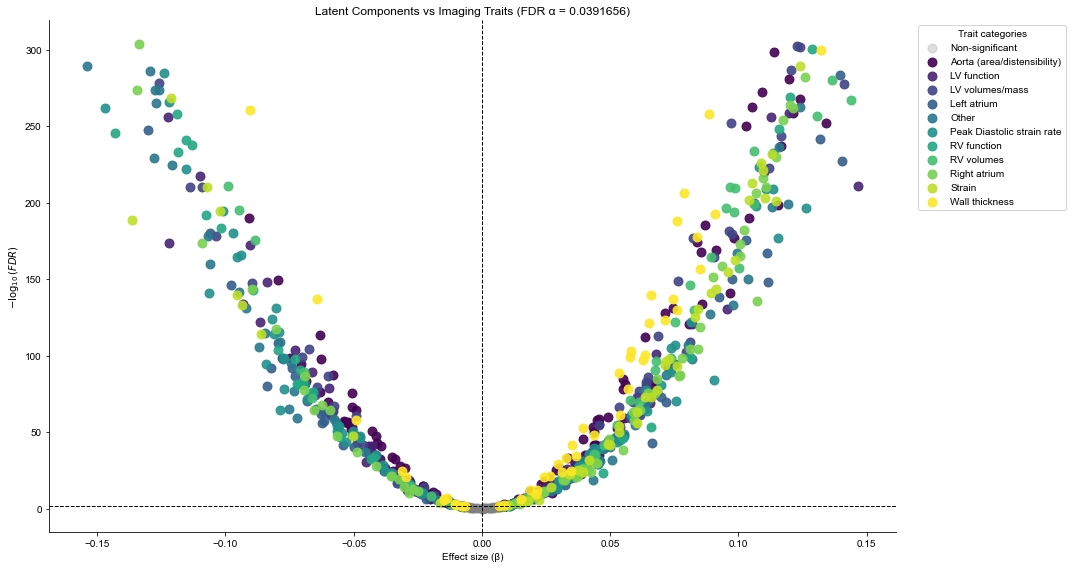

In [28]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Masks
sig = volcano_df['FDR_Significant'].fillna(False)
ns  = ~sig

# Non-significant (gray)
plt.scatter(
    volcano_df.loc[ns, 'Effect_Size'],
    volcano_df.loc[ns, '-log10(P_Value_FDR_corrected)'],
    color='gray', alpha=0.25, s=80, label='Non-significant'
)

# Significant: color by Category with viridis
cats = sorted(volcano_df.loc[sig, 'Category2'].fillna('Other').unique())  # sorted for stable color mapping
cmap = plt.cm.get_cmap('viridis', len(cats))  # discrete samples from viridis .. tab20
cat_colors = {cat: cmap(i) for i, cat in enumerate(cats)}

for cat in cats:
    sub = volcano_df.loc[sig & (volcano_df['Category2'] == cat)]
    if sub.empty:
        continue
    plt.scatter(
        sub['Effect_Size'],
        sub['-log10(P_Value_FDR_corrected)'],
        color=cat_colors[cat], alpha=0.9, s=80, #edgecolor='none',
        label=cat
    )

# Threshold lines (FDR)
y_thr = -np.log10(fdr_threshold)  # e.g., fdr_threshold = 0.05
plt.axhline(y=y_thr, linestyle='--', color='black', linewidth=1)
plt.axvline(x=0, linestyle='--', color='black', linewidth=1)

plt.xlabel('Effect size (β)')
plt.ylabel(r'$-\log_{10}(FDR)$')
plt.title(f'Latent Components vs Imaging Traits (FDR α = {fdr_threshold:g})')

plt.legend(
    bbox_to_anchor=(1.02, 1), loc='upper left',
    title='Trait categories', ncol=1, frameon=True
)

plt.tight_layout()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


save_path = f"{RESULTS_DIR_bvae}/volcano_plot_effectsizes_significance_fdr_{fdr_threshold: .3f}_category_viridis_categories.pdf"
plt.savefig(save_path, dpi=300)
plt.show()


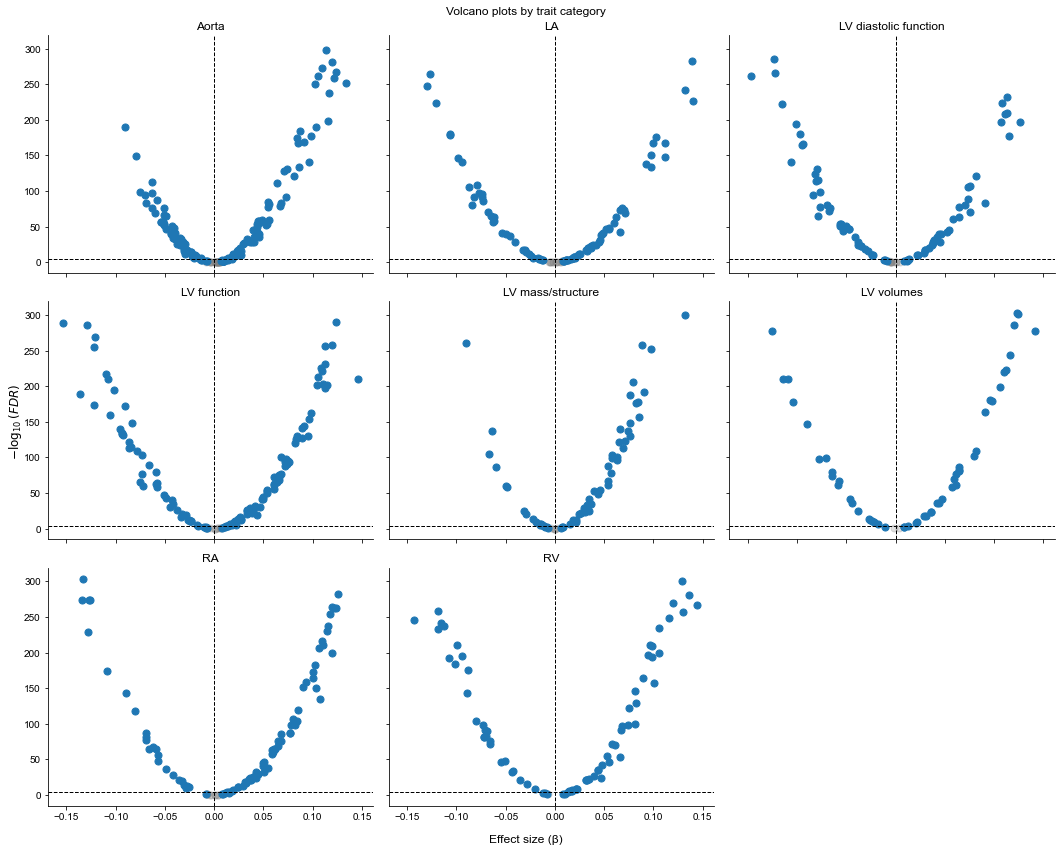

In [33]:
cats = sorted(volcano_df.loc[sig, 'Category1'].unique())
n = len(cats)
ncols = 3
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
axes = axes.ravel()

for ax, cat in zip(axes, cats):
    sub = volcano_df[volcano_df['Category1'] == cat]
    ax.scatter(sub.loc[~sub['FDR_Significant'], 'Effect_Size'],
               sub.loc[~sub['FDR_Significant'], '-log10(P_Value)'],
               color='gray', alpha=0.25, s=50)
    ax.scatter(sub.loc[sub['FDR_Significant'], 'Effect_Size'],
               sub.loc[sub['FDR_Significant'], '-log10(P_Value_FDR_corrected)'],
               s=50)
    ax.axhline(y=log_bonf_threshold, linestyle='--', color='black', linewidth=1)
    ax.axvline(x=0, linestyle='--', color='black', linewidth=1)
    ax.set_title(cat)
    # ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


save_path = f"{RESULTS_DIR_bvae}/volcano_plot_effectsizes_significance_fdr_{fdr_threshold : .3f}_per_category1.pdf"
plt.savefig(save_path, dpi=300)

# Hide unused subplots
for ax in axes[len(cats):]:
    ax.axis('off')

fig.supxlabel('Effect size (β)')
fig.supylabel(r'$-\log_{10}(FDR)$')
fig.suptitle('Volcano plots by trait category', y=0.98)
plt.tight_layout()
plt.show()


### Environmental exposure–motion latent component associations

Saved to: P:/motion_code/DR_motion/SPTVAE/results_VAE_optuna_10k/VAE_32/exposure_volcano_df_oct_sex_FDR.csv


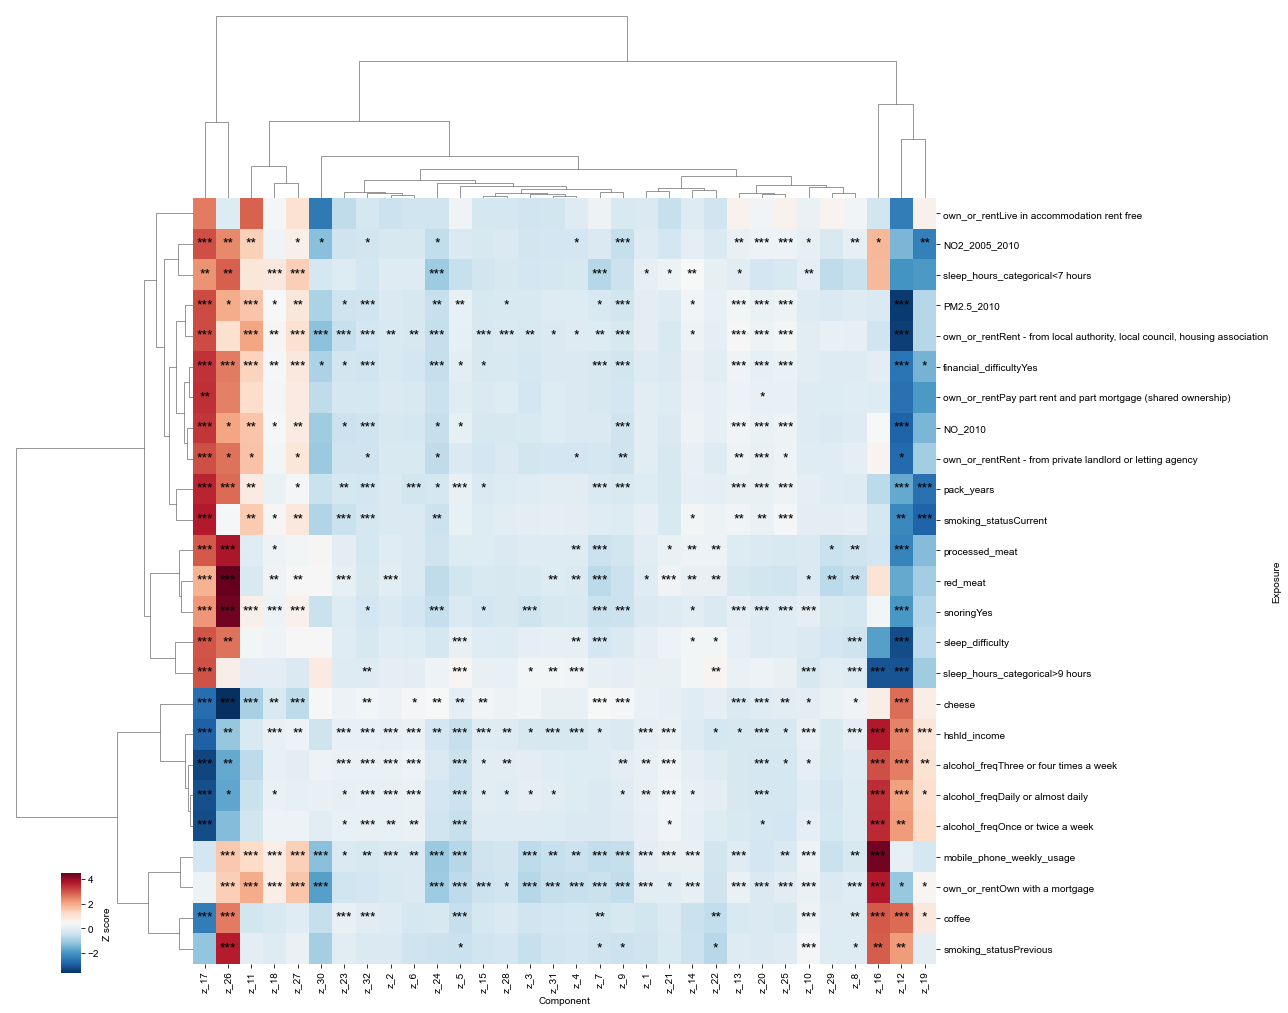

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Load data

# exp_volcano_df = pd.read_csv(f"{RESULTS_DIR_bvae}/exposure_volcano_df.csv")
exp_volcano_df = pd.read_csv(f"{RESULTS_DIR_bvae}/exposure_volcano_df_oct_sex.csv")

exp_volcano_df



# Define significance threshold
alpha = 0.05

# Mark significant results
exp_volcano_df["Significant"] = exp_volcano_df["P_Value"] < alpha

# Optional: multiple testing correction
from statsmodels.stats.multitest import multipletests
exp_volcano_df["FDR_corrected"] = multipletests(exp_volcano_df["P_Value"], method="fdr_bh")[1]  ## this is global FDR corrected
exp_volcano_df["Significant_FDR"] = exp_volcano_df["FDR_corrected"] < alpha

# save_path = f"{RESULTS_DIR_bvae}/exposure_volcano_df_FDR.csv"
save_path = f"{RESULTS_DIR_bvae}/exposure_volcano_df_oct_sex_FDR.csv"


exp_volcano_df.to_csv(save_path, index=False)
print(f"Saved to: {save_path}")


# Pivot to wide format
exp_effect_matrix = exp_volcano_df.pivot(
    index='Component', columns='Exposure', values='Effect_Size'
)

# Scale the effect size matrix
# it standardizes each column of your matrix independently
# For each exposure, all betas (across components) are converted to z-scores.
exp_effect_matrix_scaled = pd.DataFrame(
    StandardScaler().fit_transform(exp_effect_matrix),
    index=exp_effect_matrix.index,
    columns=exp_effect_matrix.columns
)

# # Clustermap on raw betas
# sns.clustermap(
#     exp_effect_matrix.T,
#     cmap='RdBu_r',
#     figsize=(14, 10),
#     metric='euclidean',
#     method='ward',
#     cbar_kws={'shrink': 0.3, 'label': 'Beta'},
#     cbar_pos=(0.05, 0.03, 0.015, 0.1)  # (x, y, width, height)
# )
# save_path = f"{RESULTS_DIR_bvae}/Effectsize_exposure_latents_80k_Beta.pdf"
# # plt.savefig(save_path, dpi=300)
# plt.show()

# # Clustermap on scaled betas
# sns.clustermap(
#     exp_effect_matrix_scaled.T,
#     cmap='RdBu_r',
#     figsize=(14, 10),
#     metric='euclidean',
#     method='ward',
#     cbar_kws={'shrink': 0.3, 'label': 'Z score'},
#     cbar_pos=(0.05, 0.03, 0.015, 0.1)
# )
# # save_path = f"{RESULTS_DIR_bvae}/Effectsize_exposure_latents_80k_z_score.pdf"
# # plt.savefig(save_path, dpi=300)
# plt.show()

# import numpy as np

# import numpy as np

# Function to convert p-values to stars
def p_to_stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

# # Pivot p-values and map to stars
# sig_markers = exp_volcano_df.pivot(
#     index="Component", columns="Exposure",  values="FDR", ### We can do Global correction with using : values="FDR_corrected"              ###values="P_Value"
# ).applymap(p_to_stars)


sig_markers = exp_volcano_df.pivot(
    index="Component", columns="Exposure", values="FDR_corrected" , ### We can do Global correction with using : values="FDR_corrected"              ###values="P_Value"
).applymap(p_to_stars)

g = sns.clustermap(
    exp_effect_matrix_scaled.T,
    cmap='RdBu_r',
    figsize=(18, 14),
    metric='euclidean',
    method='ward',
    cbar_kws={'shrink': 0.3, 'label': 'Z score'},
    cbar_pos=(0.05, 0.03, 0.015, 0.1)

)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

# Get reordered labels
x_labels = g.data2d.columns
y_labels = g.data2d.index

# Loop over each cell and add text
for y, exposure in enumerate(y_labels):
    for x, component in enumerate(x_labels):
        star = sig_markers.loc[component, exposure]
        if star != "":
            g.ax_heatmap.text(
                x + 0.5, y + 0.5, star,
                ha='center', va='center', color='black', fontsize=14, 
            )
save_path = f"{RESULTS_DIR_bvae}/Effectsize_exposure_latents_80k_zscore_FDR_sig_oct.pdf"
         
# save_path = f"{RESULTS_DIR_bvae}/Effectsize_exposure_latents_80k_zscore_eachreg_FDR_sig_oct.pdf"
plt.savefig(save_path, dpi=300)            
plt.show()

# exp_volcano_df = pd.read_csv(f"{RESULTS_DIR_bvae}/exposure_volcano_df.csv")
# exp_volcano_df

In [39]:
exp_volcano_df

,Component,Exposure,Effect_Size,SE,CI_L,CI_U,P_Value,FDR,Variable,Category,Significant,FDR_corrected,Significant_FDR
0,z_1,alcohol_freqOnce or twice a week,0.001985,NaN,0.000263,0.003706,2.383397e-02,7.150191e-02,alcohol_freq,Alcohol,True,5.156194e-02,False
1,z_1,alcohol_freqThree or four times a week,0.002795,NaN,0.001085,0.004504,1.355238e-03,6.505141e-03,alcohol_freq,Alcohol,True,4.300921e-03,True
2,z_1,alcohol_freqDaily or almost daily,0.003223,NaN,0.001449,0.004998,3.699820e-04,2.219891e-03,alcohol_freq,Alcohol,True,1.372687e-03,True
3,z_1,processed_meat,0.001230,NaN,0.000097,0.002363,3.333287e-02,8.888767e-02,processed_meat,Diet,True,6.790358e-02,False
4,z_1,red_meat,0.001692,NaN,0.000543,0.002841,3.898759e-03,1.337659e-02,red_meat,Diet,True,1.077826e-02,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,z_32,sleep_hours_categorical>9 hours,-0.002335,NaN,-0.003611,-0.001059,3.340850e-04,6.681700e-04,sleep_hours_categorical,Sleep,True,1.257732e-03,True
764,z_32,pack_years,-0.001267,NaN,-0.001667,-0.000868,4.870000e-10,2.920000e-09,pack_years,Smoking,True,5.534118e-09,True
765,z_32,smoking_statusCurrent,-0.002506,NaN,-0.003736,-0.001276,6.540000e-05,1.569850e-04,smoking_status,Smoking,True,2.937263e-04,True
766,z_32,smoking_statusPrevious,0.000337,NaN,-0.000306,0.000980,3.038150e-01,3.314346e-01,smoking_status,Smoking,False,3.948053e-01,False
